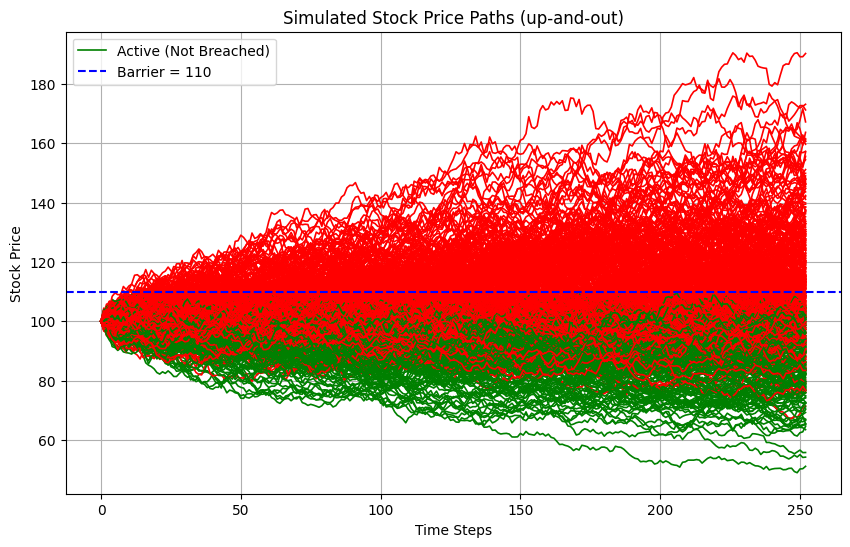

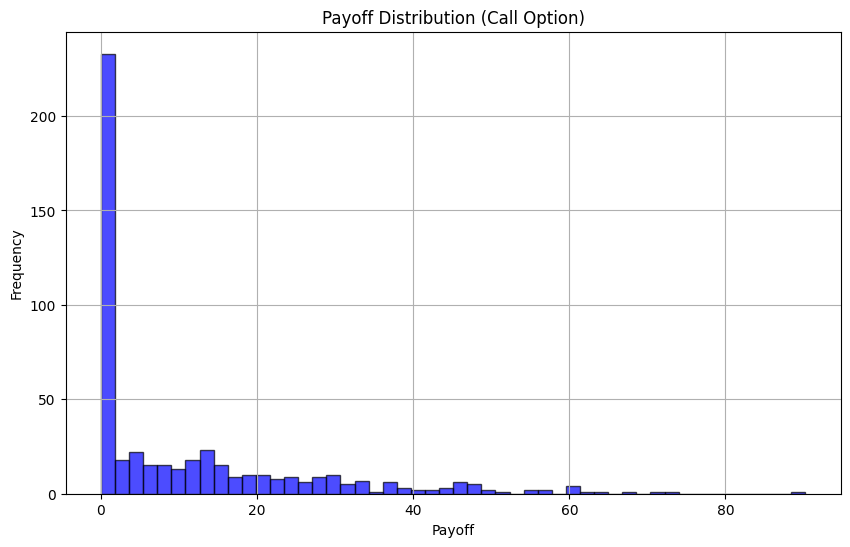

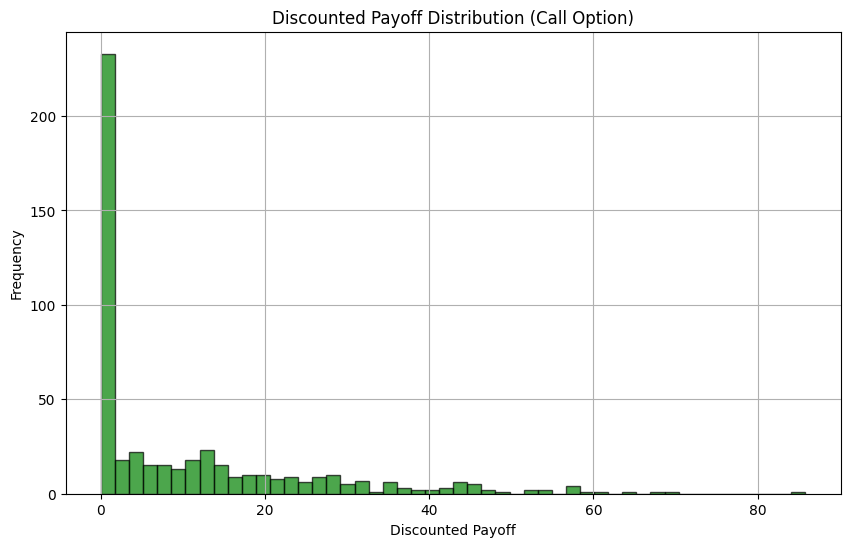

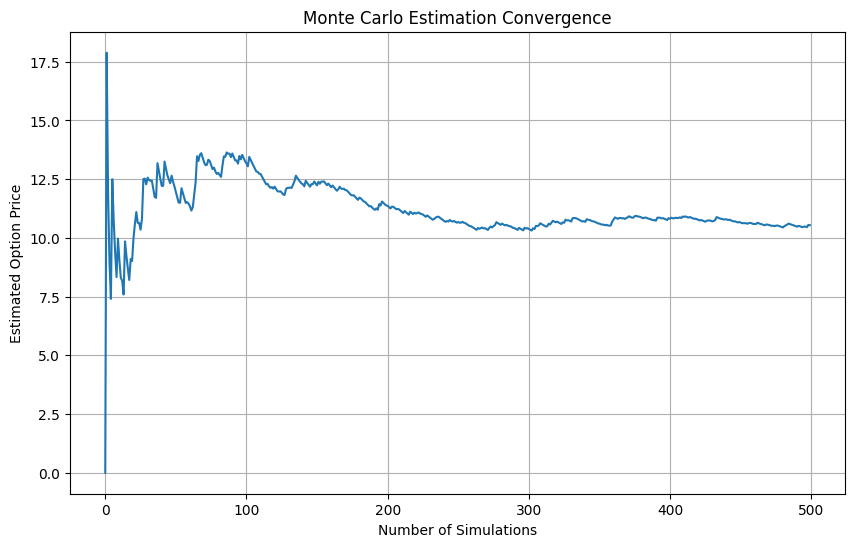

In [124]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Simulate Geometric Brownian Motion price paths
def simulate_gbm_paths(S0, T, r, sigma, N, M):
    dt = T / M  # Time step
    paths = np.zeros((N, M + 1))  # Array to store price paths
    paths[:, 0] = S0  # Set initial price for each path

    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)  # Random normal variables
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return paths

# 2. Check the barrier condition, assigning a tag of 1 or 0 for each path
def check_barrier_condition(paths, H, barrier_type):
    if 'down' in barrier_type:
        barrier_breached = np.any(paths <= H, axis=1)  # Down-and-Out/Down-and-In: breached if price falls below barrier
    else:
        barrier_breached = np.any(paths >= H, axis=1)  # Up-and-Out/Up-and-In: breached if price rises above barrier

    # If barrier is breached, tag it as 1 (breached), otherwise tag as 0
    return barrier_breached.astype(int)

# 3. Calculate Payoffs
def calculate_payoffs(paths, K, H, barrier_breached, option_type, barrier_type):
    ST = paths[:, -1]  # Get the final price at maturity
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)  # Call option payoff
    else:
        payoffs = np.maximum(K - ST, 0)  # Put option payoff

    # Adjust payoffs based on the barrier condition
    if 'out' in barrier_type:
        payoffs[barrier_breached == 1] = 0  # Knock-Out: Payoff is zero if barrier is breached
    elif 'in' in barrier_type:
        payoffs[barrier_breached == 0] = 0  # Knock-In: Payoff is zero if barrier is not breached

    return payoffs

# 4. Discount the Payoffs
def discount_payoffs(payoffs, r, T):
    return np.exp(-r * T) * payoffs  # Discount to present value

# 5. Run the Monte Carlo simulation
def run_simulation(S0, K, H, T, r, sigma, N, M, barrier_type, option_type):
    paths = simulate_gbm_paths(S0, T, r, sigma, N, M)
    barrier_breached = check_barrier_condition(paths, H, barrier_type)
    payoffs = calculate_payoffs(paths, K, H, barrier_breached, option_type, barrier_type)
    discounted_payoffs = discount_payoffs(payoffs, r, T)
    option_price = np.mean(discounted_payoffs)
    return paths, barrier_breached, discounted_payoffs, option_price

# 6. Plot the price paths, color non-active paths (those that breached barrier)
def plot_paths(paths, barrier_breached, H, barrier_type):
    plt.figure(figsize=(10, 6))
    N = len(paths)
    for i in range(N):
        if barrier_breached[i] == 1:
            plt.plot(paths[i], lw=1.2, color='red', label='Inactive (Breached Barrier)' if i == 0 else "")
        else:
            plt.plot(paths[i], lw=1.2, color='green', label='Active (Not Breached)' if i == 0 else "")

    # Add the barrier level to the plot
    plt.axhline(y=H, color='blue', linestyle='--', label=f'Barrier = {H}')
    plt.title(f'Simulated Stock Price Paths ({barrier_type})')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
S0 = 100  # Initial stock price
K = 100   # Strike price
H = 110   # Barrier level
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 500   # Number of simulations
M = 252   # Time steps (daily)
barrier_type = 'up-and-out'  # Barrier type: up-and-out or down-and-in
option_type = 'call'  # Option type: call or put

# Run the simulation
paths, barrier_breached, discounted_payoffs, option_price = run_simulation(S0, K, H, T, r, sigma, N, M, barrier_type, option_type)

# Plot the paths
plot_paths(paths, barrier_breached, H, barrier_type)

# Calculate Payoff for Call Option
payoffs = np.maximum(paths[:, -1] - K, 0)  # Call option payoff
plt.figure(figsize=(10, 6))
plt.hist(payoffs, bins=50, color='b', edgecolor='black', alpha=0.7)
plt.title('Payoff Distribution (Call Option)')
plt.xlabel('Payoff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Discount Payoffs
discounted_payoffs = np.exp(-r * T) * payoffs
plt.figure(figsize=(10, 6))
plt.hist(discounted_payoffs, bins=50, color='g', edgecolor='black', alpha=0.7)
plt.title('Discounted Payoff Distribution (Call Option)')
plt.xlabel('Discounted Payoff')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Monte Carlo Estimation: Convergence
mc_estimates = np.cumsum(discounted_payoffs) / np.arange(1, N+1)
plt.figure(figsize=(10, 6))
plt.plot(mc_estimates, lw=1.5)
plt.title('Monte Carlo Estimation Convergence')
plt.xlabel('Number of Simulations')
plt.ylabel('Estimated Option Price')
plt.grid(True)
plt.show()



In [125]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# 1. Simulate Geometric Brownian Motion price paths
def simulate_gbm_paths(S0, T, r, sigma, N, M):
    dt = T / M  # Time step
    paths = np.zeros((N, M + 1))  # Array to store price paths
    paths[:, 0] = S0  # Set initial price for each path

    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)  # Random normal variables
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return paths

# 2. Check the barrier condition, assigning a tag of 1 or 0 for each path
def check_barrier_condition(paths, H, barrier_type):
    if 'down' in barrier_type:
        barrier_breached = np.any(paths <= H, axis=1)  # Down barrier: breached if price falls below H
    if 'up' in barrier_type:
        barrier_breached = np.any(paths >= H, axis=1)  # Up barrier: breached if price rises above H

    return barrier_breached.astype(int)

# 3. Calculate Payoffs
def calculate_payoffs(paths, K, H, barrier_breached, option_type, barrier_type):
    ST = paths[:, -1]  # Get the final price at maturity
    if option_type == 'call':
        payoffs = np.maximum(ST - K, 0)  # Call option payoff
    if option_type == 'put':
        payoffs = np.maximum(K - ST, 0)  # Put option payoff

    # Adjust payoffs based on the barrier condition
    if 'out' in barrier_type:
        payoffs[barrier_breached == 1] = 0  # Knock-Out: Payoff is zero if barrier is breached
    if 'in' in barrier_type:
        payoffs[barrier_breached == 0] = 0  # Knock-In: Payoff is zero if barrier is not breached

    return payoffs

# 4. Discount the Payoffs
def discount_payoffs(payoffs, r, T):
    return np.exp(-r * T) * payoffs  # Discount to present value

# 5. Calculate Option Price and Confidence Interval
def option_price_with_confidence_interval(discounted_payoffs, N, r, T):
    # Mean of the discounted payoffs
    Gc0 = np.mean(discounted_payoffs)
    
    # Standard deviation of the discounted payoffs
    sigma_Y_n = np.std(discounted_payoffs)
    
    # Standard error
    standard_error = sigma_Y_n / np.sqrt(N)
    
    # 95% Confidence Interval based on Central Limit Theorem
    z = 1.96  # Z-score for 95% confidence
    lower_bound = Gc0 - z * standard_error
    upper_bound = Gc0 + z * standard_error

    confidence_interval = (lower_bound, upper_bound)
    
    return Gc0, confidence_interval, sigma_Y_n

# 6. Run the Monte Carlo simulation with pricing and confidence interval
def run_simulation_with_pricing(S0, K, H, T, r, sigma, N, M, barrier_type, option_type):
    paths = simulate_gbm_paths(S0, T, r, sigma, N, M)
    barrier_breached = check_barrier_condition(paths, H, barrier_type)
    payoffs = calculate_payoffs(paths, K, H, barrier_breached, option_type, barrier_type)
    discounted_payoffs = discount_payoffs(payoffs, r, T)

    # Calculate the option price and confidence interval
    Gc0, confidence_interval, sigma_Y_n = option_price_with_confidence_interval(discounted_payoffs, N, r, T)
    
    return paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n

# 7. Plot the price paths, color non-active paths (those that breached barrier)
def plot_paths(paths, barrier_breached, H, barrier_type):
    plt.figure(figsize=(10, 6))
    N = len(paths)

    for i in range(N):
        # Knock-Out: Breached barrier results in the option becoming inactive (red)
        if barrier_breached[i] == 1 and 'out' in barrier_type:
            plt.plot(paths[i], lw=1.2, color='red', label='Inactive (Breached Barrier)' if i == 0 else "")
        # Knock-In: Breached barrier results in the option becoming active (green)
        elif barrier_breached[i] == 1 and 'in' in barrier_type:
            plt.plot(paths[i], lw=1.2, color='green', label='Active (Breached Barrier)' if i == 0 else "")
        # If the barrier was not breached
        elif barrier_breached[i] == 0 and 'in' in barrier_type:
            plt.plot(paths[i], lw=1.2, color='gray', label='Inactive (Did Not Breach)' if i == 0 else "")
        elif barrier_breached[i] == 0 and 'out' in barrier_type:
            plt.plot(paths[i], lw=1.2, color='green', label='Active (Not Breached)' if i == 0 else "")

    # Add the barrier level to the plot
    plt.axhline(y=H, color='blue', linestyle='--', label=f'Barrier = {H}')
    plt.title(f'Simulated Stock Price Paths ({barrier_type})')
    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()


Up-and-Out Call - Estimated Option Price: 1.0929, 95% Confidence Interval: (np.float64(0.8311412256870911), np.float64(1.3546700731208545))


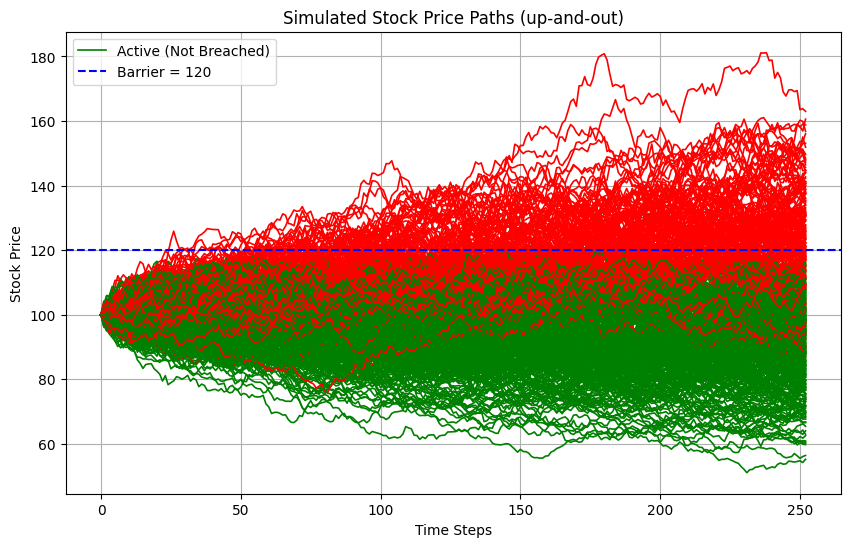

Down-and-In Call - Estimated Option Price: 0.0375, 95% Confidence Interval: (np.float64(-0.006917785604007715), np.float64(0.08182550738559188))


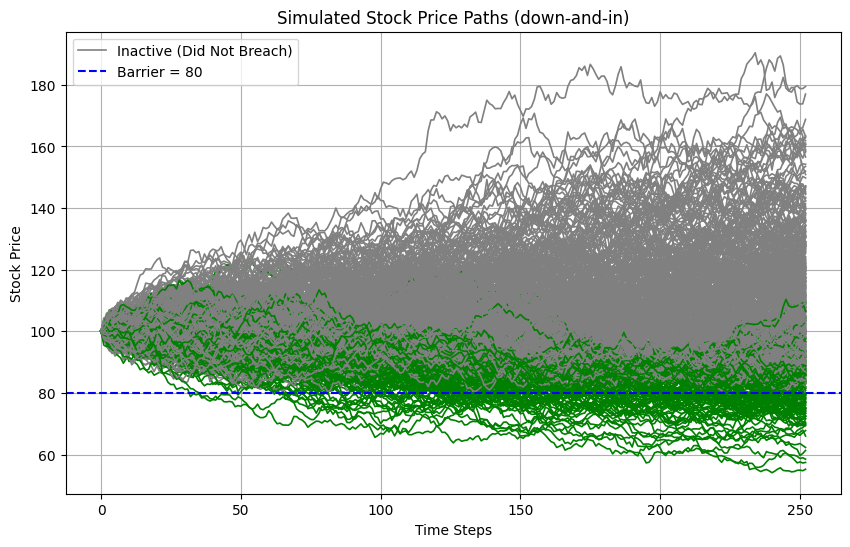

Up-and-In Call - Estimated Option Price: 9.0852, 95% Confidence Interval: (np.float64(7.7567790378638355), np.float64(10.413711551723372))


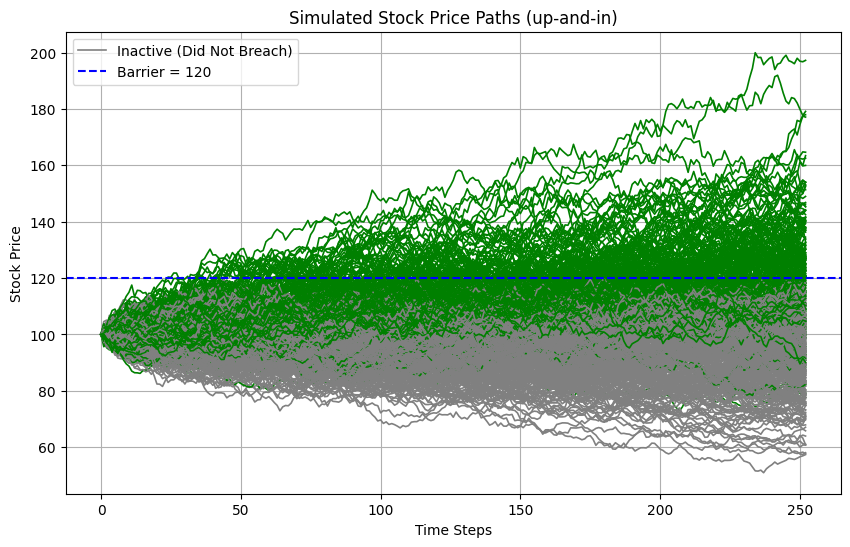

Down-and-Out Call - Estimated Option Price: 10.7835, 95% Confidence Interval: (np.float64(9.51848081135779), np.float64(12.048456721220564))


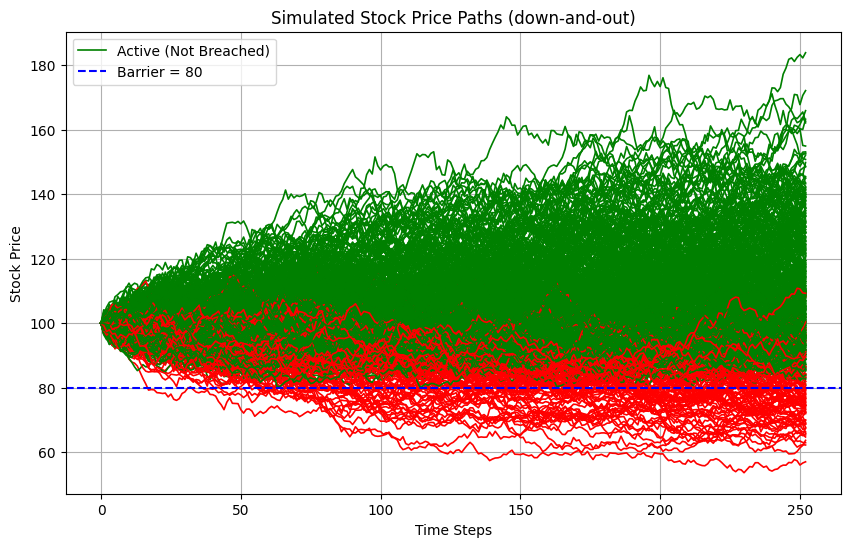

In [126]:
# Example usage of different scenarios for Call options
S0 = 100  # Initial stock price
K = 100   # Strike price
T = 1.0   # Time to maturity (1 year)
r = 0.05  # Risk-free rate
sigma = 0.2  # Volatility
N = 500   # Number of simulations
M = 252   # Time steps (daily)

# Example 1: Up-and-Out Call Option
H = 120   # Barrier level
barrier_type = 'up-and-out'
option_type = 'call'
paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(S0, K, H, T, r, sigma, N, M, barrier_type, option_type)
print(f"Up-and-Out Call - Estimated Option Price: {Gc0:.4f}, 95% Confidence Interval: {confidence_interval}")
plot_paths(paths, barrier_breached, H, barrier_type)

# Example 2: Down-and-In Call Option
H = 80    # Barrier level
barrier_type = 'down-and-in'
option_type = 'call'
paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(S0, K, H, T, r, sigma, N, M, barrier_type, option_type)
print(f"Down-and-In Call - Estimated Option Price: {Gc0:.4f}, 95% Confidence Interval: {confidence_interval}")
plot_paths(paths, barrier_breached, H, barrier_type)

# Example 3: Up-and-In Call Option
H = 120   # Barrier level
barrier_type = 'up-and-in'
option_type = 'call'
paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(S0, K, H, T, r, sigma, N, M, barrier_type, option_type)
print(f"Up-and-In Call - Estimated Option Price: {Gc0:.4f}, 95% Confidence Interval: {confidence_interval}")
plot_paths(paths, barrier_breached, H, barrier_type)

# Example 4: Down-and-Out Call Option
H = 80    # Barrier level
barrier_type = 'down-and-out'
option_type = 'call'
paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(S0, K, H, T, r, sigma, N, M, barrier_type, option_type)
print(f"Down-and-Out Call - Estimated Option Price: {Gc0:.4f}, 95% Confidence Interval: {confidence_interval}")
plot_paths(paths, barrier_breached, H, barrier_type)


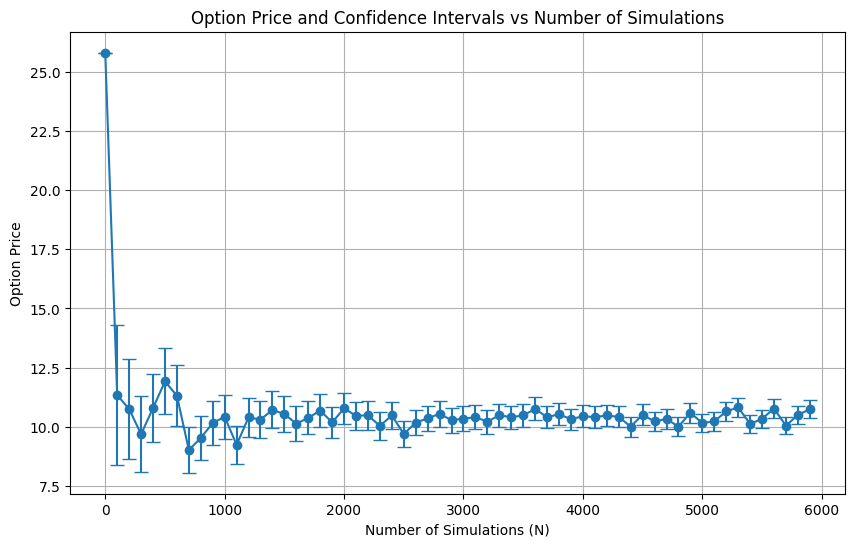

N=1, Standard Error: 0.000000
N=101, Standard Error: 1.392291
N=201, Standard Error: 1.118506
N=301, Standard Error: 0.832613
N=401, Standard Error: 0.667897
N=501, Standard Error: 0.605681
N=601, Standard Error: 0.599535
N=701, Standard Error: 0.589902
N=801, Standard Error: 0.519231
N=901, Standard Error: 0.513882
N=1001, Standard Error: 0.446271
N=1101, Standard Error: 0.438272
N=1201, Standard Error: 0.436452
N=1301, Standard Error: 0.384375
N=1401, Standard Error: 0.406541
N=1501, Standard Error: 0.385949
N=1601, Standard Error: 0.353486
N=1701, Standard Error: 0.343787
N=1801, Standard Error: 0.334662
N=1901, Standard Error: 0.343179
N=2001, Standard Error: 0.335148
N=2101, Standard Error: 0.321574
N=2201, Standard Error: 0.306081
N=2301, Standard Error: 0.314976
N=2401, Standard Error: 0.305958
N=2501, Standard Error: 0.310999
N=2601, Standard Error: 0.281715
N=2701, Standard Error: 0.282606
N=2801, Standard Error: 0.286101
N=2901, Standard Error: 0.269571
N=3001, Standard Error

In [127]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252

# Simulate for varying number of simulations to observe the impact on the confidence interval
simulation_sizes = range(1,6000,100) # Number of simulations to test
option_prices = []
conf_intervals = []

for N in simulation_sizes:
    paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(
        S0, K, H, T, r, sigma, N, M, barrier_type='up-and-out', option_type='call')
    option_prices.append(Gc0)
    conf_intervals.append(confidence_interval)

# Convert confidence intervals to upper and lower bounds for error bars
lower_bound = [op - ci[0] for op, ci in zip(option_prices, conf_intervals)]
upper_bound = [ci[1] - op for op, ci in zip(option_prices, conf_intervals)]

# Plot the option price with confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(simulation_sizes, option_prices, yerr=[lower_bound, upper_bound], fmt='-o', capsize=5)
plt.title('Option Price and Confidence Intervals vs Number of Simulations')
plt.xlabel('Number of Simulations (N)')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


# Standard Error Calculation and Plotting
for N in simulation_sizes:
    paths = simulate_gbm_paths(S0, T, r, sigma, N, M)
    payoffs = np.maximum(paths[:, -1] - K, 0)  # Call option payoff
    discounted_payoffs = np.exp(-r * T) * payoffs
    
    # Standard Error over different N
    standard_error = np.std(discounted_payoffs) / np.sqrt(N)
    
    print(f"N={N}, Standard Error: {standard_error:.6f}")

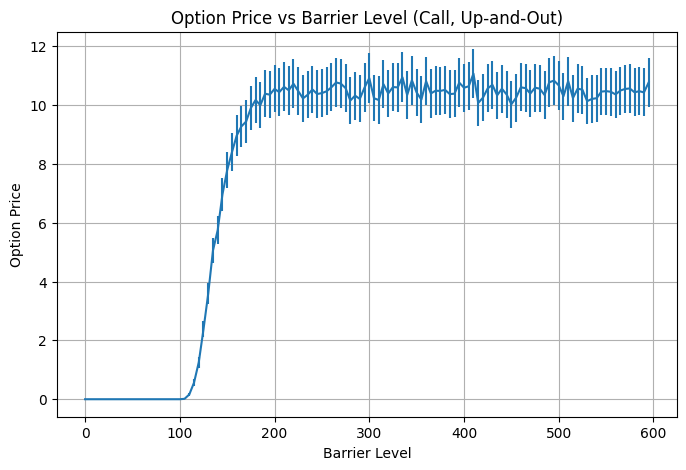

In [128]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252
barriers = range(0,600,5)
#[110, 120, 130]  # Example barrier levels
option_prices = []
conf_intervals = []

for H in barriers:
    # Run the simulation for each barrier level
    paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(
        S0, K, H, T, r, sigma, N, M, barrier_type='up-and-out', option_type='call')
    option_prices.append(Gc0)
    conf_intervals.append(confidence_interval)

# Plot the option price as a function of the barrier level
plt.figure(figsize=(8, 5))
plt.errorbar(barriers, option_prices, yerr=[ci[1] - ci[0] for ci in conf_intervals], fmt='-')
plt.title('Option Price vs Barrier Level (Call, Up-and-Out)')
plt.xlabel('Barrier Level')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


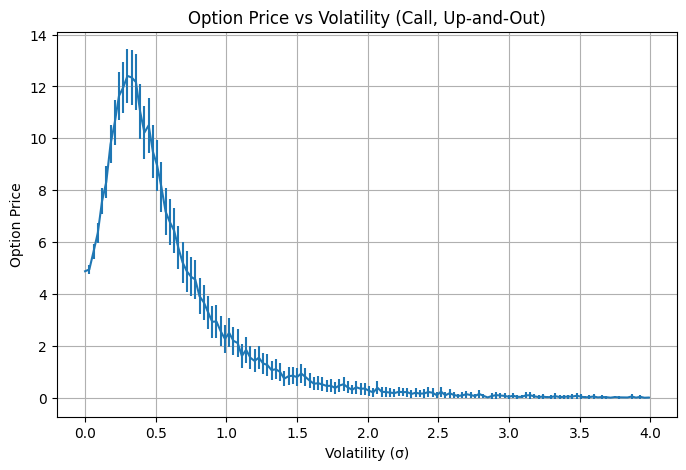

In [129]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252
volatilities = np.arange(0.0, 4.0, 0.03)# Example volatilities
option_prices = []
conf_intervals = []

for sigma in volatilities:
    paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(
        S0, K, H, T, r, sigma, N, M, barrier_type='up-and-out', option_type='call')
    option_prices.append(Gc0)
    conf_intervals.append(confidence_interval)

# Plot the option price as a function of volatility
plt.figure(figsize=(8, 5))
plt.errorbar(volatilities, option_prices, yerr=[ci[1] - ci[0] for ci in conf_intervals], fmt='-')
plt.title('Option Price vs Volatility (Call, Up-and-Out)')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


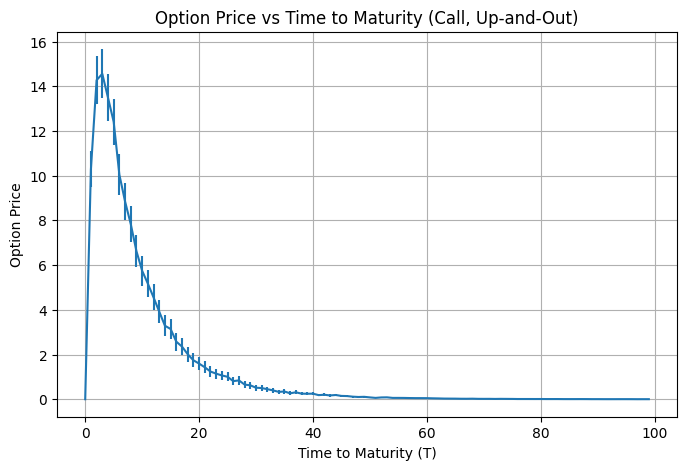

In [130]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252

maturities = range(0,100,1)  # Example maturities in years
option_prices = []
conf_intervals = []

for T in maturities:
    paths, barrier_breached, discounted_payoffs, Gc0, confidence_interval, sigma_Y_n = run_simulation_with_pricing(
        S0, K, H, T, r, sigma, N, M, barrier_type='up-and-out', option_type='call')
    option_prices.append(Gc0)
    conf_intervals.append(confidence_interval)

# Plot the option price as a function of time to maturity
plt.figure(figsize=(8, 5))
plt.errorbar(maturities, option_prices, yerr=[ci[1] - ci[0] for ci in conf_intervals], fmt='-')
plt.title('Option Price vs Time to Maturity (Call, Up-and-Out)')
plt.xlabel('Time to Maturity (T)')
plt.ylabel('Option Price')
plt.grid(True)
plt.show()


C:\Users\hassa\AppData\Local\Temp\ipykernel_14972\2541384712.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


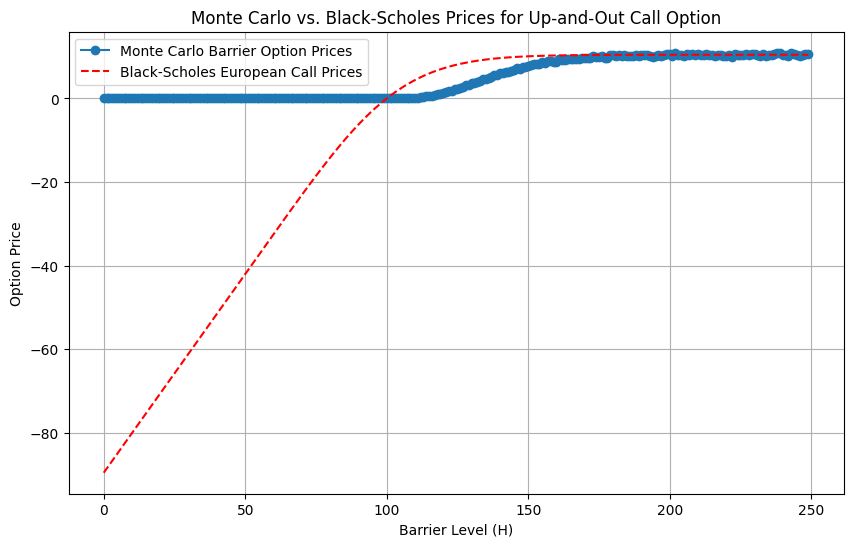

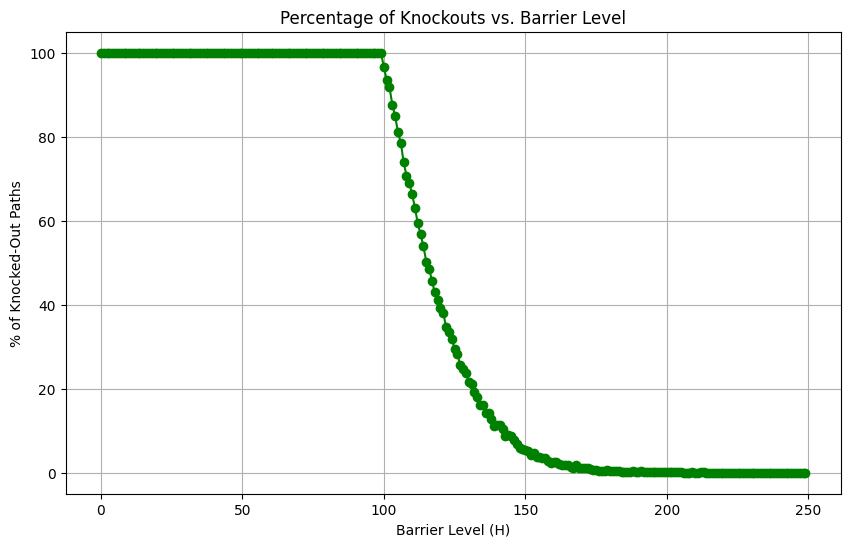

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Parameters
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252

# Function to simulate stock price paths using GBM
def simulate_gbm_paths(S0, T, r, sigma, N, M):
    dt = T / M
    paths = np.zeros((N, M + 1))
    paths[:, 0] = S0
    for t in range(1, M + 1):
        Z = np.random.standard_normal(N)
        paths[:, t] = paths[:, t - 1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return paths

# Monte Carlo simulation function for barrier options
def run_monte_carlo_barrier_pricing(S0, K, H, T, r, sigma, N, M, barrier_type='up-and-out'):
    paths = simulate_gbm_paths(S0, T, r, sigma, N, M)
    
    # Check if the barrier was breached at any time for each path
    barrier_breached = np.any(paths > H, axis=1)  # Up-and-out condition: price exceeds H
    
    # Calculate the payoff for call options (knock-out if breached)
    payoffs = np.maximum(paths[:, -1] - K, 0)  # Call option payoff at maturity
    payoffs[barrier_breached] = 0  # Set payoff to 0 if the barrier was breached
    
    # Discount payoffs back to present value
    discounted_payoffs = np.exp(-r * T) * payoffs
    
    # Return the mean price and percentage of knocked-out paths
    knock_out_percentage = np.mean(barrier_breached) * 100
    return np.mean(discounted_payoffs), knock_out_percentage

# Black-Scholes European call option pricing formula
def black_scholes_call(S0, K, T, r, sigma):
    d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Varying the barrier level
barriers = np.arange(0, 250, 1)  # Barrier levels from 100 to 600
mc_prices = []
bs_prices = []
knockout_percentages = []

for H in barriers:
    # Monte Carlo price for barrier option
    mc_price, knockout_percentage = run_monte_carlo_barrier_pricing(S0, K, H, T, r, sigma, N, M)
    mc_prices.append(mc_price)
    knockout_percentages.append(knockout_percentage)
    
    # Black-Scholes price for European call (as a reference)
    bs_price = black_scholes_call(S0, K, T, r, sigma) - black_scholes_call(S0, H, T, r, sigma)
    bs_prices.append(bs_price)

# Plot the results: Monte Carlo and Black-Scholes
plt.figure(figsize=(10, 6))
plt.plot(barriers, mc_prices, label='Monte Carlo Barrier Option Prices', marker='o')
plt.plot(barriers, bs_prices, label='Black-Scholes European Call Prices', linestyle='--', color='red')
plt.title('Monte Carlo vs. Black-Scholes Prices for Up-and-Out Call Option')
plt.xlabel('Barrier Level (H)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()

# Plot the percentage of knockouts vs. barrier level
plt.figure(figsize=(10, 6))
plt.plot(barriers, knockout_percentages, label='% Knockouts', color='green', marker='o')
plt.title('Percentage of Knockouts vs. Barrier Level')
plt.xlabel('Barrier Level (H)')
plt.ylabel('% of Knocked-Out Paths')
plt.grid(True)
plt.show()


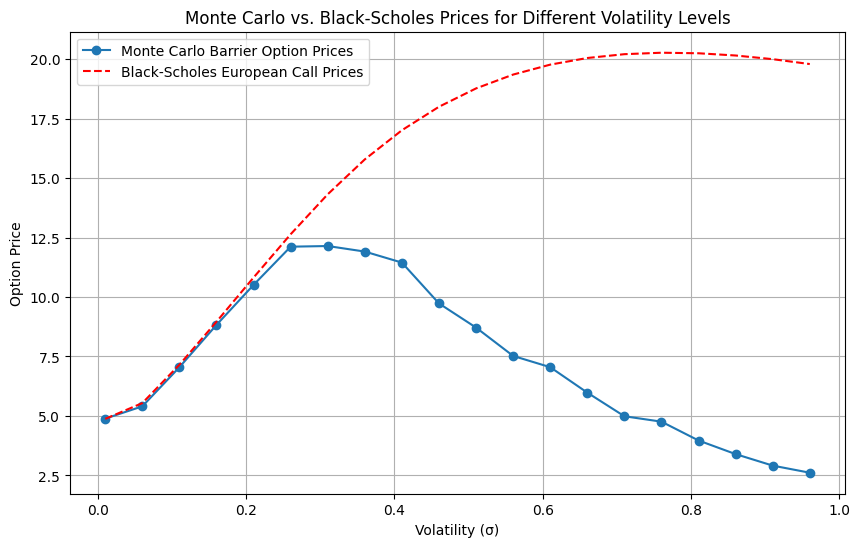

In [4]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252

# Varying the volatility
volatilities = np.arange(0.01, 1.0, 0.05)  # Range of volatilities
mc_prices_vol = []
bs_prices_vol = []

for sigma in volatilities:
    # Monte Carlo price for barrier option
    mc_price, _ = run_monte_carlo_barrier_pricing(S0, K, H, T, r, sigma, N, M)
    mc_prices_vol.append(mc_price)
    
    # Black-Scholes price for European call (as a reference)
    bs_price = black_scholes_call(S0, K, T, r, sigma)  - black_scholes_call(S0, H, T, r, sigma)
    bs_prices_vol.append(bs_price)

# Plot the results for volatility
plt.figure(figsize=(10, 6))
plt.plot(volatilities, mc_prices_vol, label='Monte Carlo Barrier Option Prices', marker='o')
plt.plot(volatilities, bs_prices_vol, label='Black-Scholes European Call Prices', linestyle='--', color='red')
plt.title('Monte Carlo vs. Black-Scholes Prices for Different Volatility Levels')
plt.xlabel('Volatility (σ)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\hassa\AppData\Local\Temp\ipykernel_14972\2541384712.py:38: RuntimeWarning: invalid value encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
C:\Users\hassa\AppData\Local\Temp\ipykernel_14972\2541384712.py:38: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


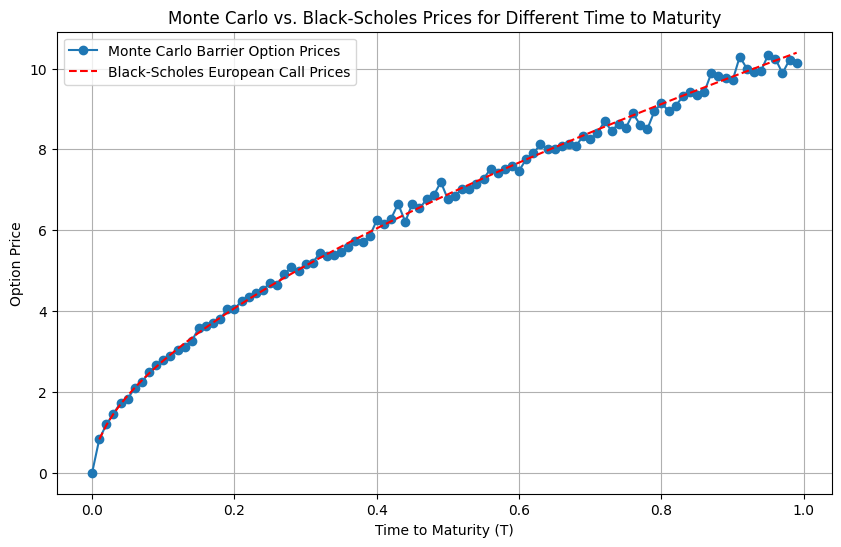

In [5]:
S0, K, H, T, r, sigma, N, M = 100, 100, 200, 1.0, 0.05, 0.2, 5000, 252

# Varying the time to maturity
maturities = np.arange(0, 1.0, 0.01)  # Range of maturities in years
mc_prices_maturity = []
bs_prices_maturity = []

for T in maturities:
    # Monte Carlo price for barrier option
    mc_price, _ = run_monte_carlo_barrier_pricing(S0, K, H, T, r, sigma, N, M)
    mc_prices_maturity.append(mc_price)
    
    # Black-Scholes price for European call (as a reference)
    bs_price = black_scholes_call(S0, K, T, r, sigma) -  - black_scholes_call(S0, H, T, r, sigma)
    bs_prices_maturity.append(bs_price)

# Plot the results for time to maturity
plt.figure(figsize=(10, 6))
plt.plot(maturities, mc_prices_maturity, label='Monte Carlo Barrier Option Prices', marker='o')
plt.plot(maturities, bs_prices_maturity, label='Black-Scholes European Call Prices', linestyle='--', color='red')
plt.title('Monte Carlo vs. Black-Scholes Prices for Different Time to Maturity')
plt.xlabel('Time to Maturity (T)')
plt.ylabel('Option Price')
plt.legend()
plt.grid(True)
plt.show()
